## Latent space are responsibilities, that is, probability of being assigned to given cluster

In [79]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from vae_lib.utils.gmm_on_circle import MixtureOfNormalsOnCircle
from vae_lib.utils.gmm_mixture_for_discrete_vae import GmmMixtureForDiscreteVae
from sklearn.utils.extmath import softmax
from vae_lib.preprocessing.data_permutation import permute
from vae_lib.utils.nn_logger import get_log_folder
from vae_lib.utils.measures import calculate_accuracy_np


ModuleNotFoundError: No module named 'vae_lib.utils.measures'

In [17]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [18]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

In [19]:
def plot_2d_latent_space(model, onehot_encoder, X, y):
    m, sd = model_supervised.encode2(X_test)
    y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
    fig = plt.figure(figsize=(20, 20))


    plt.subplot(2, 2, 1)
    plt.scatter(m[:,0], m[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.scatter(sd[:,0], sd[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.scatter(m[:,0], sd[:,0], c=y_decoded, cmap='brg')
    plt.colorbar()

    Z = np.random.normal(m,sd)
    plt.subplot(2, 2, 4)
    plt.scatter(Z[:,0], Z[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.show()

### Import MNIST

In [20]:
mnist = tf.keras.datasets.mnist

### Load data

In [21]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [22]:
y_train.shape

(60000,)

In [23]:
X = np.concatenate((X_train, X_test), axis=0)

In [24]:
n_all_cases = X.shape[0]
input_dim = X.shape[1]

In [25]:
X = np.reshape(X, (n_all_cases, -1))
y = np.concatenate((y_train, y_test)).astype('float32')

In [26]:
label_reshaped = y.reshape(len(y), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [27]:
n_classes = onehot_encoded.shape[1]

In [28]:
X = (X > 0.5).astype(np.float32)

In [29]:
X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

### Utility functions

In [32]:
def accuracy_for_score(y_pred, y_true, score, threshold):
    cond = score > threshold
    accuracy = calculate_accuracy_np(y_pred[cond], y_true[cond])
    return accuracy

In [33]:
def classification_ratio(score, threshold):
    cond = score > threshold
    above_threshold = np.mean((score > threshold).astype(int))
    return above_threshold

In [34]:
def plot_many_images(images, labels, rows=4, columns=3):

    ROW = rows
    COLUMN = columns
    for i in range(ROW * COLUMN):
        # train[i][0] is i-th image data with size 28x28
        image = images[i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
        plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
        plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
        # train[i][1] is i-th digit label
        plt.title('label = {}'.format(labels[i]))
        plt.axis('off')  # do not show axis value
    plt.tight_layout()   # automatic padding between subplots
    #plt.savefig('images/mnist_plot.png')
    plt.show()

### Build neural network

In [35]:
class DenseLayer:

    def __init__(self, in_dim, out_dim, f=tf.nn.relu, name="dense"):
        self.name = name
        with tf.name_scope(self.name):
            self.f = f
            initializer = tf.contrib.layers.xavier_initializer()
            self.W = tf.Variable(initializer((in_dim, out_dim)), name="W")
            self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
            tf.summary.histogram("weights", self.W)
            tf.summary.histogram("bias", self.b)

    def forward(self, X):
        with tf.name_scope(self.name):
            act = self.f(tf.matmul(X, self.W) + self.b)
            tf.summary.histogram("activation", act)
            return act

In [83]:
class VClassifier:

    def encode(self, X, middle_layer_dim):
        current_value = X
        for layer in self.encoder_layers:
            current_value = layer.forward(current_value)

        means = current_value[:, :middle_layer_dim]
        tmp = current_value[:, middle_layer_dim:]
#         stdevs = tf.sqrt(tf.exp(tmp))
        stdevs = tf.nn.softplus(tmp) + 1e-6
        
        
        return means, stdevs
    
    def create_encoder(self, X, input_dim, hidden_dims):
        
        in_dim = input_dim
        for h_dim in hidden_dims[:-1]:
            h = DenseLayer(in_dim, h_dim)
            self.encoder_layers.append(h)
            in_dim = h_dim

        middle_layer_dim = 2 #hidden_dims[-1]
        self.encoder_layers.append(DenseLayer(in_dim, 2 * middle_layer_dim, f=lambda x: x))

        return self.encode(X, middle_layer_dim)
    
    def decode(self, Z, output_dim, hidden_dims):
        decoder_layers = []

        in_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
            h = DenseLayer(in_dim, hidden_dim)
            decoder_layers.append(h)
            in_dim = hidden_dim

        decoder_layers.append(DenseLayer(in_dim, output_dim, f=lambda x: x))

        current_value = Z
        for decoder_layer in decoder_layers:
            current_value = decoder_layer.forward(current_value)

        return current_value
    
    def calculateKL(self, mean, std):
        inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
        kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
        return tf.math.reduce_mean(kls)
    
    def create_accuracy_node(self, y_true, y_pred):
        correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
        return accuracy_node
    
    def entropy(self, p):
        per_row_entropy = -tf.reduce_sum(p * tf.log(p+1e-20), axis=1)
        return tf.reduce_mean(per_row_entropy)

    def __init__(self, x_dim, y_dim, hidden_dims, log_folder, alpha, beta, gamma, omega, delta, r, batch_sz=64):
        self.encoder_layers = []
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layer = 1
        self.ANNEAL_RATE=0.0003
        self.MIN_TEMP=0.01
        self.batch_sz = batch_sz
        
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
        self.y = tf.placeholder(tf.float32, shape=(None, y_dim), name="y")
        self.temperature_123 = tf.Variable(0.3,name="temperature", dtype=tf.float32, trainable=False)
        self.current_temperature = 0.3
        self.hard = tf.placeholder(tf.bool, name="hard")
        
        init_cov = np.array([
            [0.07,0.0],
            [0.0,0.007]
        ], dtype="float64")

        batched_betas = np.tile([np.ones(10)/10], [64,1])
        
        init_angles = [(2 * i * np.pi) / 10 for i in range(10)]
#         thetas = tf.get_variable(initializer=init_angles, name="thetas")
        thetas = tf.constant(init_angles, name="thetas")
        self.mix = GmmMixtureForDiscreteVae(init_cov, r=r, batch_size=64, batched_betas=batched_betas, thetas=thetas)

        #encoder
        self.means, self.stdevs = self.create_encoder(self.X, x_dim, hidden_dims)

        n = Normal(
          loc=self.means,
          scale=self.stdevs,
        )
        Z = n.sample()
        
        self.resp_soft = tf.cast(self.mix.responsibilities(tf.cast(Z, dtype=tf.float64)), dtype=tf.float32)
#         self.resp = self.resp_soft

        def soft_responsibilities_with_softmax():
            resp = tf.nn.softmax(self.resp_soft/self.temperature_123)
            return self.resp_soft
        
        def hard_responsibilities():
            resp_hard = tf.cast(tf.equal(self.resp_soft,tf.reduce_max(self.resp_soft,1,keep_dims=True)),self.resp_soft.dtype)
            resp = tf.stop_gradient(resp_hard - self.resp_soft) + self.resp_soft
            return resp

        self.resp = tf.cond(self.hard, lambda: hard_responsibilities(), lambda: soft_responsibilities_with_softmax())
        
#         self.resp_tmp = tf.cast(self.mix.responsibilities(tf.cast(self.means, dtype=tf.float64)), dtype=tf.float32)
#         self.resp = tf.nn.softmax(self.resp_tmp/self.temperature_123)


        #decoder
        self.logits = self.decode(self.resp, (x_dim+y_dim), hidden_dims)

        self.XY_hat_distribution = Bernoulli(logits=self.logits)

        self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)
        self.score = tf.norm(self.means, axis=1)
        
        if y_dim > 0:
            self.posterior_predictive_probs_y = self.posterior_predictive_probs[:,x_dim:(x_dim+y_dim)]
            print("self.posterior_predictive_probs_y.shape {}".format(self.posterior_predictive_probs_y.get_shape().as_list()))
            print("self.y.shape {}".format(self.y.get_shape().as_list()))
            self.accuracy_node = self.create_accuracy_node(self.y, self.posterior_predictive_probs_y)
            tf.summary.scalar("accuracy", self.accuracy_node)

        with tf.name_scope('COST'):
            
            if y_dim > 0:
                xy = tf.concat([self.X, self.y], axis=1)
            else:
                xy = self.X
            print("xy.shape {}".format(xy.get_shape().as_list()))

            expected_log_likelihood_2 = -tf.reduce_sum(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=self.logits[:,0:x_dim]), 
                axis=1
            )

            kl = self.calculateKL(self.means, self.stdevs)
            tf.summary.scalar("KL", kl)

            gmm_cost = self.mix.penalty_term_with_gd(Z)
            tf.summary.scalar("gmm_cost", gmm_cost)
            
            exp_loglik_2 = tf.reduce_mean(expected_log_likelihood_2)
            tf.summary.scalar("loglik_2", exp_loglik_2)
            
            entropy_of_hidden = self.entropy(self.resp)
            tf.summary.scalar("entropy_of_hidden", entropy_of_hidden)
            
            if y_dim > 0:
                cross_entropy_classifier = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits[:,x_dim:(x_dim+y_dim)])
                avg_cross_entropy_classifier = -tf.reduce_mean(cross_entropy_classifier)
                tf.summary.scalar("softmax_cross_entropy", avg_cross_entropy_classifier)
                elbo = alpha * exp_loglik_2 + beta * kl + gamma * avg_cross_entropy_classifier - omega*gmm_cost - delta*entropy_of_hidden
            else:
                elbo = alpha * exp_loglik_2 + beta * kl - omega*gmm_cost
                
            tf.summary.scalar("ELBO", elbo)
            
        
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(-elbo)
        #self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-elbo)

        self.init_op = tf.global_variables_initializer()
            
        #InteractiveSession.close()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

        self.merged_summary = tf.summary.merge_all()

        self.writer_train = tf.summary.FileWriter(log_folder)
        self.writer_train.add_graph(self.sess.graph)

    def fit(self, X_train, y_train, epochs=30, starting_temperature=0.3):
        #costs=[]
        n_batches = len(X_train) // self.batch_sz
        print("n_batches:", n_batches)
        self.current_temperature=starting_temperature
        isHard = False

        iter = 1
        for i in range(epochs):
            print("epoch: %d" % i)
            #np.random.shuffle(X_train)
            X_train, y_train = permute(X_train, y_train)
            for j in range(n_batches):
                batch_x = X_train[j * self.batch_sz:(j + 1) * self.batch_sz]
                
                if self.y_dim > 0:
                    batch_y = y_train[j * self.batch_sz:(j + 1) * self.batch_sz]
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.y: batch_y, self.temperature_123:self.current_temperature, self.hard: isHard})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.y: batch_y, self.temperature_123:self.current_temperature, self.hard:isHard})
                        self.writer_train.add_summary(s, iter)
                else:
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.temperature_123:self.current_temperature, self.hard:isHard})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.temperature_123:self.current_temperature, self.hard:isHard})
                        self.writer_train.add_summary(s, iter)
                    
                iter += 1
            
#             self.current_temperature=np.maximum(starting_temperature*np.exp(-self.ANNEAL_RATE*iter),self.MIN_TEMP)
#             print("Temperature: {}".format(self.current_temperature))
            if i == 5:
                isHard = True

            
#             if self.y_dim > 0:
#                 train_accuracy = self.calculate_accuracy(X_train, y_train)
#                 print("Train accuracy {}".format(train_accuracy))

        
    def calculate_accuracy(self, X, y):
        accuracy = self.sess.run(self.accuracy_node, feed_dict={self.X: X, self.y: y})
        return accuracy
        
    def predict(self, X):
        y_pred = self.sess.run([self.posterior_predictive_probs_y, self.score], feed_dict={self.X: X})
        return y_pred
    
    def predict_X(self, X,x_dim):
        
        print("Temperature: {}".format(self.current_temperature))
        resps, raw_resps = self.sess.run([self.resp, self.resp_tmp], feed_dict={self.X: X, self.temperature_123:self.current_temperature})
        X_pred = self.sess.run(self.posterior_predictive_probs, feed_dict={self.resp: resps})
        return X_pred[:,:x_dim], resps, raw_resps
    
    def predict_X_resps(self, X,x_dim):
        
        #print("Temperature: {}".format(self.current_temperature))
        resps = self.sess.run(self.resp, feed_dict={self.X: X, self.temperature_123:self.current_temperature, self.hard:False})
        X_pred = self.sess.run(self.posterior_predictive_probs, feed_dict={self.resp: resps, self.hard:False})
        return X_pred[:,:x_dim], resps


    def predict_X_resps_all(self, X):
        all_rows = np.empty([0, self.y_dim], dtype = float)
        n_rows = len(X)
        n_batches = n_rows // self.batch_sz
        last_row = 0
        for j in range(n_batches):
            batch_x = X[j * self.batch_sz:(j + 1) * self.batch_sz]
            last_row = (j + 1) * self.batch_sz
            #print("Processing rows {}-{}".format(j * self.batch_sz,(j + 1) * self.batch_sz))

            _, resps = self.predict_X_resps(X=batch_x, x_dim=self.x_dim)
            #print(resps.shape)
            #resps_label = np.argmax(resps, axis=1)
            all_rows = np.append(all_rows, resps, axis=0)

        if last_row < n_rows:
            start_row = n_rows-64
            batch_x = X[start_row:n_rows]
            #print("Processing rows {}-{}".format(start_row,n_rows))
            _, resps = self.predict_X_resps(X=batch_x, x_dim=self.x_dim)

            num_rows = n_rows - last_row
            last_resps = resps[-num_rows:,:]
            all_rows = np.append(all_rows, last_resps, axis=0)
            
        return all_rows
    
    def encode2(self, X):
        means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
        return means, stdevs
    
    def encode_to_discrete(self, X):
        responsibilities = self.sess.run(self.resp, feed_dict={self.X: X})
        return responsibilities
    
    def sampleLatent(self, X):
        means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
        n = Normal(
          loc=means,
          scale=stdevs,
        )
        Z = n.sample()
        return Z
    
    

### Supervised VAE

In [84]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = VClassifier(
    x_dim=X_train.shape[1], 
    y_dim=y_train.shape[1], 
    hidden_dims=[512, 256, 128, 10], 
    log_folder=log_folder,
    alpha=1,#0,
    beta=0,
    gamma=0,#1,
    omega=0.005,
    delta=2,
    r=1
)
model_supervised.fit(X_train, y_train, epochs=2)

# test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
# print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/23_04_2019/20190423114340
self.posterior_predictive_probs_y.shape [64, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
epoch: 1


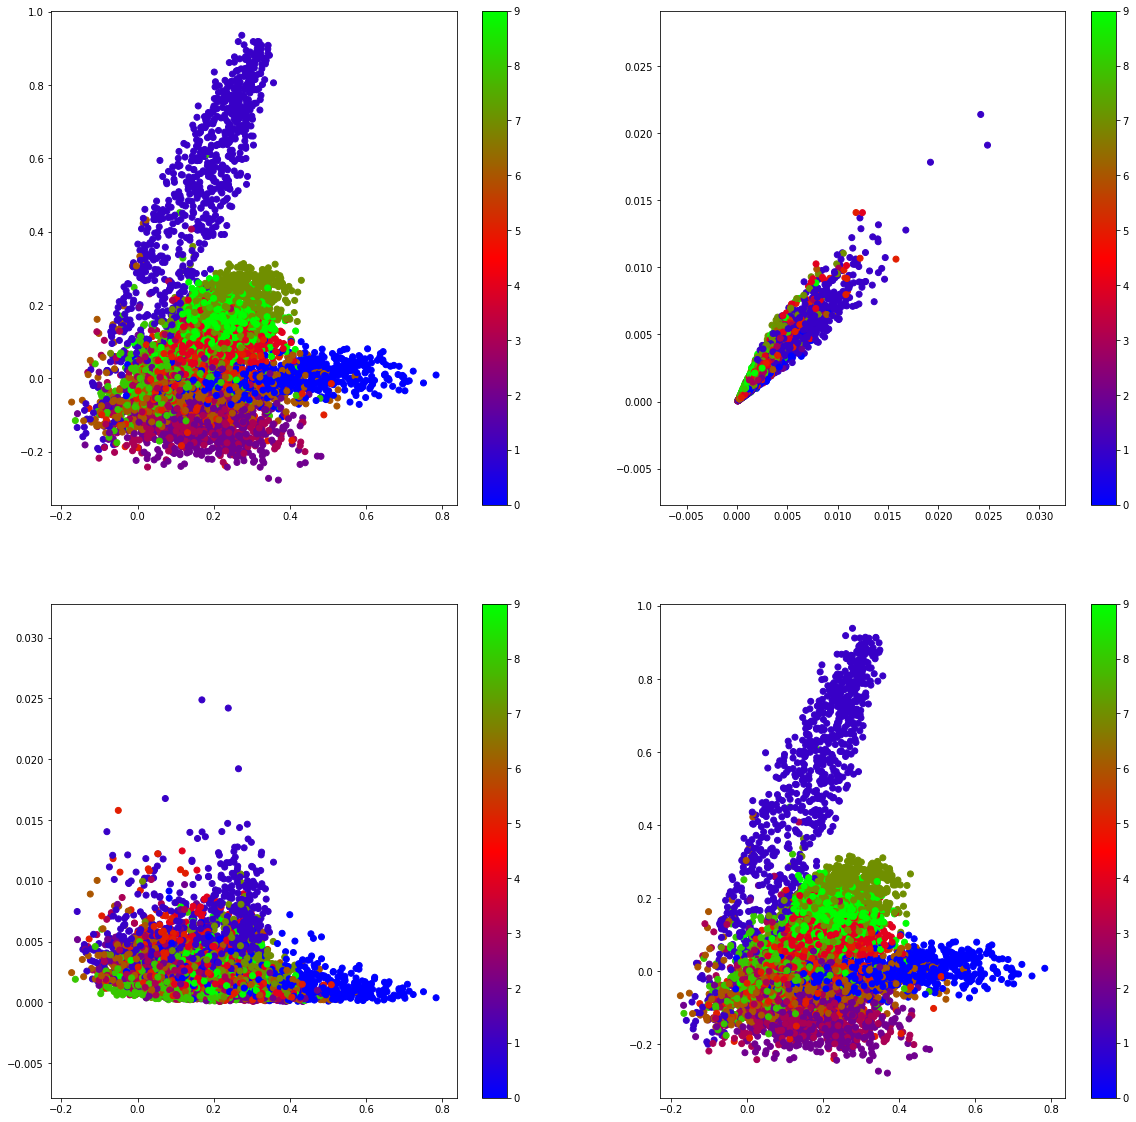

In [85]:
plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)

In [71]:
images_from_standard_normal_flat, resps = model_supervised.predict_X_resps(X=X_train[0:64,:], x_dim=X_train.shape[1])
images_from_standard_normal = images_from_standard_normal_flat.reshape((64,28,28)).shape
resps_rounded = np.around(resps, decimals=3)
resps_label = np.argmax(resps[0:64,:], axis=1)

In [74]:
np.around(resps[0:3,:], decimals=3)

array([[0.015, 0.069, 0.322, 0.418, 0.118, 0.022, 0.009, 0.008, 0.009,
        0.008],
       [0.   , 0.   , 0.073, 0.926, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.001, 0.055, 0.842, 0.1  , 0.001, 0.   , 0.   , 0.   ,
        0.   ]], dtype=float32)

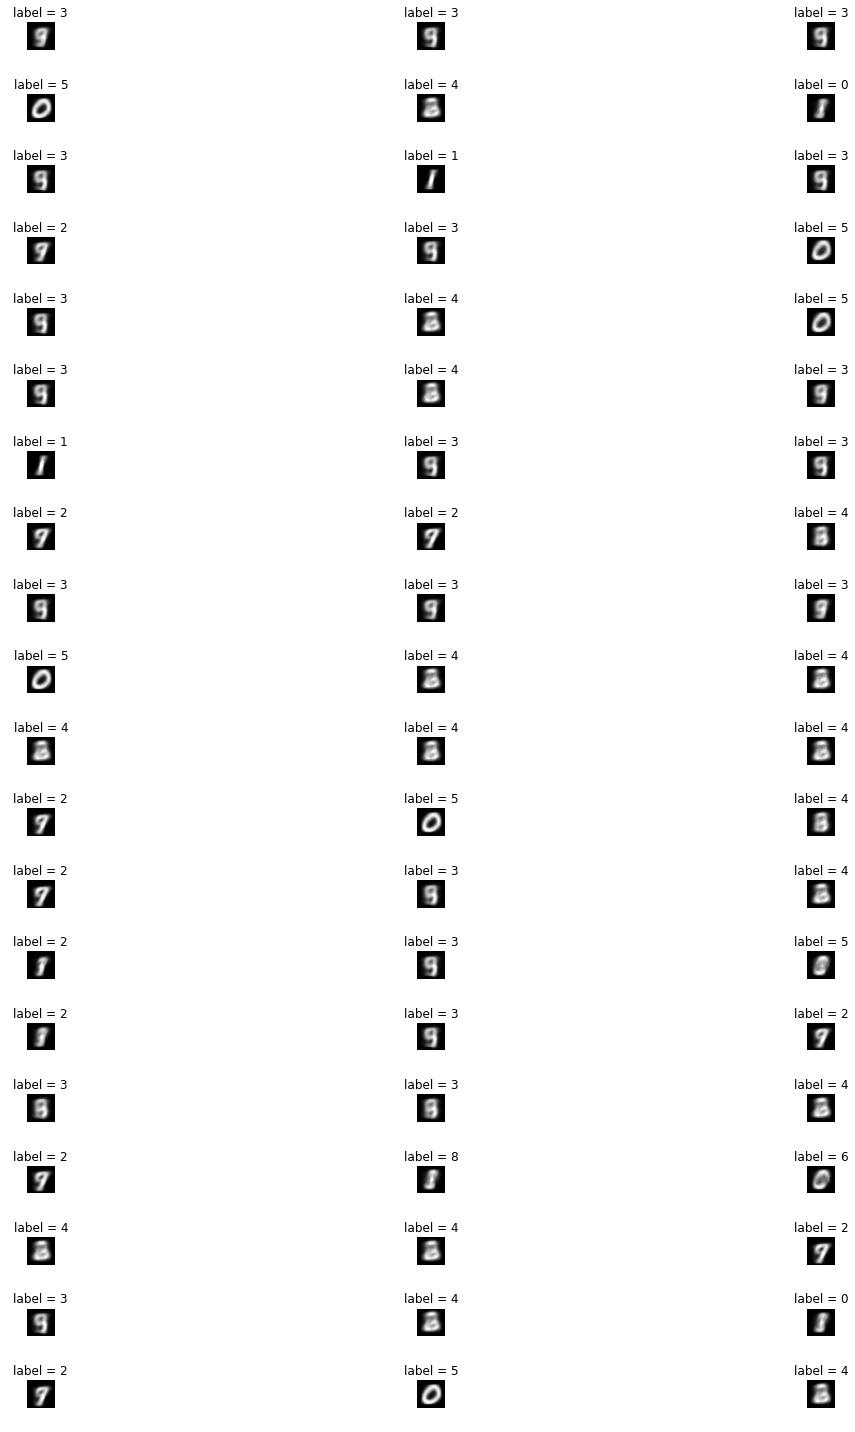

In [75]:
plt.figure(figsize=(20,20))
plot_many_images(images_from_standard_normal_flat, resps_label, rows=20)

In [86]:
all_rows = model_supervised.predict_X_resps_all(
    X=X_train)

In [87]:
all_rows.shape

(63000, 10)

In [78]:
calculate_accuracy_np(all_rows, y_train)

0.15788888888888888

In [99]:
np.argmax(all_rows, axis=1)

array([4, 0, 0, ..., 8, 5, 3])

In [100]:
reduced_data = pd.DataFrame({
    'in': np.argmax(y_train[:62976,:], axis=1),
    'out': np.argmax(all_rows, axis=1)
})
reduced_data.head()

,in,out
0,8,4
1,7,0
2,4,0
3,5,7
4,3,7


In [101]:
def score_for_class(true_class):
    stats = reduced_data[reduced_data['in']==true_class]
    scores = (stats.groupby(['out']).count()/len(stats)).values
    chosen_class = np.argmax(scores)
    return scores, chosen_class

In [105]:
[score_for_class(i)[1] for i in range(10)]

[2, 8, 6, 7, 0, 7, 3, 0, 7, 0]

In [104]:
score_for_class(0)

(array([[5.78964297e-03],
        [2.49276295e-02],
        [8.84850434e-01],
        [5.90221936e-02],
        [3.05564490e-03],
        [1.28658733e-03],
        [4.82470248e-04],
        [1.54390479e-02],
        [2.89482149e-03],
        [2.25152782e-03]]), 2)

In [103]:
stats = reduced_data[reduced_data['in']==5]
len(stats)

5660

In [490]:
scores = (stats.groupby(['out']).count()/len(stats)).values
scores

array([[0.01404494],
       [0.02018961],
       [0.18627107],
       [0.26369382],
       [0.16011236],
       [0.0854986 ],
       [0.00351124],
       [0.00719803],
       [0.0193118 ],
       [0.24016854]])

In [492]:
scores[np.argmax(scores)]

array([0.26369382])

In [466]:
stats = reduced_data[reduced_data['in']==4]
np.argmax(np.bincount(stats['out']))

2

In [452]:
stats

,in,out
25,3,4
44,3,4
60,3,3
70,3,3
86,3,3
90,3,4
122,3,4
137,3,3
154,3,3
156,3,4


In [47]:
model_supervised.encode2(X_test)[0].shape

(7000, 2)

In [48]:
resp = model_supervised.encode_to_discrete(X_test)

In [49]:
resp.shape

(7000, 10)

In [50]:
resp[1]

array([0.00000000e+00, 0.00000000e+00, 3.36717547e-24, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.45503545e-33, 0.00000000e+00], dtype=float32)

In [86]:
resp_train = model_supervised.encode_to_discrete(X_train)
resp_test = model_supervised.encode_to_discrete(X_test)

In [87]:
resp_train.shape, resp_test.shape, X_train.shape

((63000, 10), (7000, 10), (63000, 784))

In [88]:
np.isnan(resp_train).sum()

0

In [89]:
np.isnan(resp_test).sum()

0

In [90]:
np.argwhere(np.isnan(resp_train))

array([], shape=(0, 2), dtype=int64)

In [79]:
# resp_train[34097,:] = np.zeros(10)
# resp_train[40214,:] = np.zeros(10)

In [25]:
class SimpleNN:
    
    def __init__(self, dims):
        self.dims = dims
        self.batch_size = 64
        
        self.x = tf.placeholder(tf.float32, [None, dims[0]])
        self.y_true = tf.placeholder(tf.float32, [None, 10])

#         l1 = DenseLayer(dims[0], dims[1])
#         l2 = DenseLayer(dims[1], 10, f=lambda x: x)
#         tmp = l1.forward(self.x)
#         y_pred = l2.forward(tmp)
        
        layers = []

        in_dim = dims.pop(0)
        for h_dim in dims:
            h = DenseLayer(in_dim, h_dim)
            layers.append(h)
            in_dim = h_dim

        current_value = self.x
        for layer in layers:
            current_value = layer.forward(current_value)
        
        y_pred = current_value

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=self.y_true))
#         self.gd_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
        self.gd_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)
        
        correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.argmax(self.y_true, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))
    
    def fit(self, train_input, train_output, test_input, test_output, epochs=10):
        
        n_batches = len(train_input) // self.batch_size
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for i in range(epochs):
                for j in range(n_batches):
                    batch_x = train_input[j * self.batch_size:(j + 1) * self.batch_size]
                    batch_y = train_output[j * self.batch_size:(j + 1) * self.batch_size]
                    sess.run(self.gd_step, feed_dict={self.x: batch_x, self.y_true: batch_y})

            train_accuracy = sess.run(self.accuracy, feed_dict={self.x: train_input, self.y_true: train_output})
            test_accuracy = sess.run(self.accuracy, feed_dict={self.x: test_input, self.y_true: test_output})
            print("Train accuracy: {:.4}%".format(train_accuracy*100))
            print("Test accuracy: {:.4}%".format(test_accuracy*100))

In [26]:
# simple_nn = SimpleNN([784,512,10])
# simple_nn.fit(X_train, y_train, X_test, y_test)

In [27]:
simple_nn = SimpleNN([10,512, 256, 128, 10])
simple_nn.fit(resp_train, y_train, resp_test, y_test, epochs=10)

NameError: name 'resp_train' is not defined

In [83]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
clf.fit(resp_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [84]:
rf_predict = clf.predict(resp_test)

In [85]:
calculate_accuracy_np(y_pred=rf_predict, y_true=y_test)

0.6584285714285715

In [47]:
a = list(range(10))

In [48]:
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [51]:
a[-3:]

[7, 8, 9]